In [1]:
!pip install datasets transformers

In [2]:
from datasets import load_dataset

In [3]:
imagenette = load_dataset(
    'frgfm/imagenette',
    '320px',
    split='validation',
    revision="4d512db"
)

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for frgfm/imagenette contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/frgfm/imagenette
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

In [5]:
set(imagenette['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
# labels names 
labels = imagenette.info.features['label'].names
labels

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [7]:
# generate sentences serves as a seed text
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a tench',
 'a photo of a English springer',
 'a photo of a cassette player',
 'a photo of a chain saw',
 'a photo of a church',
 'a photo of a French horn',
 'a photo of a garbage truck',
 'a photo of a gas pump',
 'a photo of a golf ball',
 'a photo of a parachute']

In [8]:
# initialization
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

2024-05-07 21:20:36.215248: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 21:20:36.257160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 21:20:36.257204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 21:20:36.258308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 21:20:36.264881: I tensorflow/core/platform/cpu_feature_guar

In [9]:
import torch

# if you have CUDA set it to the active device like this
device = "cuda" if torch.cuda.is_available() else "cpu"
# move the model to the device
model.to(device)

device

'cuda'

In [10]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320,  1149,   634, 49407],
       device='cuda:0')

In [11]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [12]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.87605494, 0.89617455)

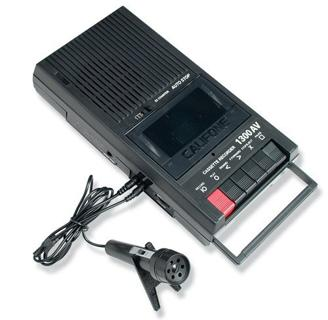

In [13]:
imagenette[0]['image']

In [14]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [15]:
img_emb = model.get_image_features(image)
img_emb.shape

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([1, 512])

In [16]:
img_emb = img_emb.detach().cpu().numpy()

In [17]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [18]:
# get index of highest score
pred = np.argmax(scores)
pred

2

In [19]:
# find text label with highest score
labels[pred]

'cassette player'

In [20]:
from tqdm.auto import tqdm

preds = []
batch_size = 32

for i in tqdm(range(0, len(imagenette), batch_size)):
    i_end = min(i + batch_size, len(imagenette))
    images = processor(
        text=None,
        images=imagenette[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/123 [00:00<?, ?it/s]

In [21]:
true_preds = []
for i, label in enumerate(imagenette['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

print(f"Test acc: {sum(true_preds) / len(true_preds)}")

Test acc: 0.9870063694267516


## CIFAR10

In [22]:
from datasets import get_dataset_split_names

In [23]:
train_data = load_dataset("cifar10", split='train')
test_data = load_dataset("cifar10", split='test')

In [24]:
train_labels = train_data.features['label'].names
train_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [25]:
# generate sentences
clip_labels = [f"a photo of a {label}" for label in train_labels]
clip_labels

['a photo of a airplane',
 'a photo of a automobile',
 'a photo of a bird',
 'a photo of a cat',
 'a photo of a deer',
 'a photo of a dog',
 'a photo of a frog',
 'a photo of a horse',
 'a photo of a ship',
 'a photo of a truck']

In [26]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320, 16451, 49407], device='cuda:0')

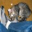

In [27]:
test_data[0]['img']

In [28]:
train_labels[test_data[0]['label']]

'cat'

In [29]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [30]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.819966, 0.9265056)

In [31]:
image = processor(
        text=None,
        images=test_data[0]['img'],
        return_tensors='pt'
)['pixel_values'].to(device)

In [32]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [33]:
img_emb = img_emb.detach().cpu().numpy()

In [34]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [35]:
# get index of highest score
pred = np.argmax(scores)
pred

3

In [36]:
train_labels[pred]

'cat'

In [37]:
from tqdm.auto import tqdm

preds = []
batch_size = 128

for i in tqdm(range(0, len(test_data), batch_size)):
    i_end = min(i + batch_size, len(test_data))
    images = processor(
        text=None,
        images=test_data[i:i_end]['img'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/79 [00:00<?, ?it/s]

In [38]:
true_preds = []
for i, label in enumerate(test_data['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

print(f"Test acc: {sum(true_preds) / len(true_preds)}")

Test acc: 0.8724


## MNIST

In [39]:
train_data = load_dataset("mnist", split='train')
test_data = load_dataset("mnist", split='test')

In [40]:
mnist_labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [41]:
train_labels = train_data.features['label'].names
train_labels


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [42]:
# generate sentences
clip_labels = [f"a photo of a {label}" for label in mnist_labels]
clip_labels

['a photo of a zero',
 'a photo of a one',
 'a photo of a two',
 'a photo of a three',
 'a photo of a four',
 'a photo of a five',
 'a photo of a six',
 'a photo of a seven',
 'a photo of a eight',
 'a photo of a nine']

In [43]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320,  5848, 49407], device='cuda:0')

In [44]:
test_data[0]['image']

In [45]:
train_labels[test_data[0]['label']]

'7'

In [46]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [47]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.8639847, 0.9492535)

In [48]:
image = processor(
        text=None,
        images=test_data[0]['image'],
        return_tensors='pt'
)['pixel_values'].to(device)

In [49]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [50]:
img_emb = img_emb.detach().cpu().numpy()

In [51]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [52]:
# get index of highest score
pred = np.argmax(scores)
pred

7

In [53]:
train_labels[pred]

'7'

In [54]:
from tqdm.auto import tqdm

preds = []
batch_size = 128

for i in tqdm(range(0, len(test_data), batch_size)):
    i_end = min(i + batch_size, len(test_data))
    images = processor(
        text=None,
        images=test_data[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/79 [00:00<?, ?it/s]

In [55]:
true_preds = []
for i, label in enumerate(test_data['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

print(f"Test acc: {sum(true_preds) / len(true_preds)}")

Test acc: 0.185


## FASHION MNIST

In [56]:
train_data = load_dataset("fashion_mnist", split='train')
test_data = load_dataset("fashion_mnist", split='test')

In [57]:
train_labels = train_data.features['label'].names
train_labels


['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [58]:
# generate sentences
clip_labels = [f"a photo of a {label}" for label in train_labels]
clip_labels

['a photo of a T - shirt / top',
 'a photo of a Trouser',
 'a photo of a Pullover',
 'a photo of a Dress',
 'a photo of a Coat',
 'a photo of a Sandal',
 'a photo of a Shirt',
 'a photo of a Sneaker',
 'a photo of a Bag',
 'a photo of a Ankle boot']

In [59]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320,   339,   268,  2523,   270,  1253],
       device='cuda:0')

In [60]:
test_data[0]['image']

In [61]:
train_labels[test_data[0]['label']]

'Ankle boot'

In [62]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [63]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.82189494, 0.8578639)

In [64]:
image = processor(
        text=None,
        images=test_data[0]['image'],
        return_tensors='pt'
)['pixel_values'].to(device)

In [65]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [66]:
img_emb = img_emb.detach().cpu().numpy()

In [67]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [68]:
# get index of highest score
pred = np.argmax(scores)
pred

7

In [69]:
train_labels[pred]

'Sneaker'

In [70]:
from tqdm.auto import tqdm

preds = []
batch_size = 128

for i in tqdm(range(0, len(test_data), batch_size)):
    i_end = min(i + batch_size, len(test_data))
    images = processor(
        text=None,
        images=test_data[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/79 [00:00<?, ?it/s]

In [71]:
true_preds = []
for i, label in enumerate(test_data['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

print(f"Test acc: {sum(true_preds) / len(true_preds)}")

Test acc: 0.602
